In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import xgboost as xgb

from causalml.dataset import make_uplift_classification
from causalml.inference.meta import BaseTClassifier, BaseXRegressor
from causalml.optimize import get_treatment_costs, get_actual_value, CounterfactualValueEstimator

import matplotlib.pyplot as plt
import seaborn as sns
from causalml.metrics import auuc_score, get_cumgain, plot_gain

sns.set_style('whitegrid')

%matplotlib inline


/home/sean/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [2]:
df, X_names = make_uplift_classification(
    n_samples=5000, treatment_name=["control", "treatment1", "treatment2"],
    positive_class_proportion=0.1
)

In [3]:
# Put costs into dicts
conversion_cost_dict = {"control": 0, "treatment1": 2.5, "treatment2": 10}
impression_cost_dict = {"control": 0, "treatment1": 0, "treatment2": 0.02}

# Use a helper function to put treatment costs to array
cc_array, ic_array, conditions = get_treatment_costs(
    treatment=df["treatment_group_key"],
    control_name="control",
    cc_dict=conversion_cost_dict,
    ic_dict=impression_cost_dict,
)

# Put the conversion value into an array
conversion_value_array = np.full(df.shape[0], 20)

In [4]:
# Use a helper function to obtain the value of actual treatment
actual_value = get_actual_value(
    treatment=df["treatment_group_key"],
    observed_outcome=df["conversion"],
    conversion_value=conversion_value_array,
    conditions=conditions,
    conversion_cost=cc_array,
    impression_cost=ic_array,
)

In [5]:
df_train, df_test = train_test_split(df)
train_idx = df_train.index
test_idx = df_test.index

### Random Policy

In [6]:
test_actual_value = actual_value.loc[test_idx]
random_treatments = pd.Series(
    np.random.choice(conditions, test_idx.shape[0]), index=test_idx
)
test_treatments = df.loc[test_idx, "treatment_group_key"]
random_allocation_value = test_actual_value[test_treatments == random_treatments]


### Best Treatment Policy

In [7]:
best_ate = df_train.groupby("treatment_group_key")["conversion"].mean().idxmax()

actual_is_best_ate = df_test["treatment_group_key"] == best_ate

best_ate_value = actual_value.loc[test_idx][actual_is_best_ate]

### T Learner

In [8]:
# Calculate the value under an uplift model
tm = BaseTClassifier(
    control_learner=xgb.XGBClassifier(),
    treatment_learner=xgb.XGBClassifier(),
    control_name="control",
)

tm.fit(
    df_train[X_names].values, df_train["treatment_group_key"], df_train["conversion"]
)

tm_pred = tm.predict(df_test[X_names].values)

pred_df = pd.DataFrame(tm_pred, columns=tm._classes)
tm_best = pred_df.idxmax(axis=1)
actual_is_tm_best = df_test["treatment_group_key"] == tm_best.ravel()
tm_value = actual_value.loc[test_idx][actual_is_tm_best]


### CVE

In [9]:
# Estimate the conditional mean model; this is a pure curve
# fitting exercise
proba_model = xgb.XGBClassifier()

W_dummies = pd.get_dummies(df["treatment_group_key"])
XW = np.c_[df[X_names], W_dummies]

proba_model.fit(XW[train_idx], df_train["conversion"])
y_proba = proba_model.predict_proba(XW[test_idx])[:, 1]

In [10]:
# Run the counterfactual calculation with TwoModel prediction
cve = CounterfactualValueEstimator(
    # treatment=df_test["treatment_group_key"],
    # treatment=pd.Series(np.random.choice(conditions, df_test.shape[0]), index=test_idx),
    treatment=['control' for _ in range(len(test_idx))],
    # treatment=0,
    control_name="control",
    treatment_names=conditions[1:],
    y_proba=y_proba,
    cate=tm_pred,
    value=conversion_value_array[test_idx],
    conversion_cost=cc_array[test_idx],
    impression_cost=ic_array[test_idx],
)

cve_best_idx = cve.predict_best()
cve_best = [conditions[idx] for idx in cve_best_idx]
actual_is_cve_best = df.loc[test_idx, "treatment_group_key"] == cve_best
cve_value = actual_value.loc[test_idx][actual_is_cve_best]
print(cve_value.mean())

2.5232399299474606


### Net Value Optimized X Learner


In [11]:
from uplift.meta_learner import NeVOX
from sklearn.preprocessing import OrdinalEncoder

encoder = {"control": 0, "treatment1": 1, "treatment2": 2}

ic_lookup = {0: 0, 1: 0.1, 2: 0.1}
cc_lookup = {0: 0, 1: 5, 2: 10}

nvex = NeVOX(ic_lookup=ic_lookup, cc_lookup=cc_lookup)

X = df.loc[train_idx, X_names].to_numpy()
y = df.loc[train_idx, "conversion"].to_numpy()
T = np.array([encoder[x] for x in df.loc[train_idx, "treatment_group_key"]])
value = np.ones(train_idx.shape[0]) * 20

nvex.fit(X, y, T, value)


In [12]:
X_test = df.loc[test_idx, X_names].to_numpy()
nvex_preds = nvex.get_best_action(X_test)

nvex_best = [conditions[idx] for idx in nvex_preds]
actual_is_nvex_best = df.loc[test_idx, "treatment_group_key"] == nvex_best
nvex_value = actual_value.loc[test_idx][actual_is_nvex_best]

In [13]:
best_possible = actual_value.iloc[test_idx]
best_possible = best_possible[best_possible > 0]
best_value = best_possible


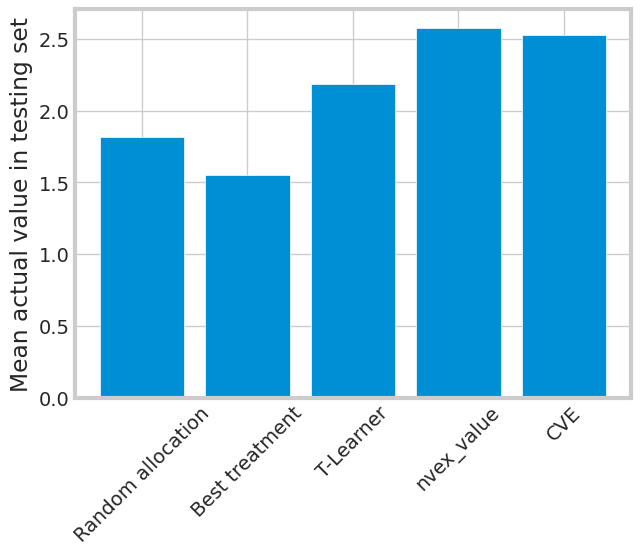

In [14]:
labels = [
    "Random allocation",
    "Best treatment",
    "T-Learner",
    "nvex_value",
    "CVE",
    # "best_possible",
]

values = [
    random_allocation_value,
    best_ate_value,
    tm_value,
    nvex_value,
    cve_value,
    # best_value,
]

bar_plot_values = [x.mean() for x in values]

plt.bar(labels, bar_plot_values)
plt.ylabel("Mean actual value in testing set")
plt.xticks(rotation=45)
plt.show()